In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

E0000 00:00:1728120434.340486      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1005 09:27:14.349337759      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1005 09:27:14.349356382      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1005 09:27:14.349360349      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1005 09:27:14.349363620      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1005 09:27:14.349366365      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

In [2]:
# Load the dataset
data = np.load('/kaggle/input/512gender2/Page2_1024_512_full.npz')
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']

# Reshape the images (from flat to original size)
X_train = X_train.reshape((-1, 512, 1024, 1))  # Grayscale
X_test = X_test.reshape((-1, 512, 1024, 1))

# Convert grayscale to 3 channels by repeating the single channel
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Normalize pixel values (0-255) to range (0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [3]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Create a strategy for distributed training
#strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1728120551.211218      13 service.cc:145] XLA service 0x5cc3704fce90 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728120551.211310      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1728120551.211316      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1728120551.211320      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1728120551.211323      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1728120551.211325      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1728120551.211328      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1728120551.211331      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1728120551.211333      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
with tpu_strategy.scope():
    # Define the base model with ImageNet weights, without the top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(512, 1024, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top of the base model
    inputs = Input(shape=(512, 1024, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Global average pooling layer
    x = Dense(128, activation='relu')(x)  # Custom dense layer
    outputs = Dense(2, activation='softmax')(x)  # Output layer for 2 classes

    # Create the final model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    

model.summary()

I0000 00:00:1728120556.081397      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 1024, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 16, 32, 512)    │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,  # You can increase epochs based on performance
                    batch_size=16,
                    callbacks=[early_stopping])

# Save the model in .keras format
model.save('AP-VGG16_Model_1024Gender_Trained.keras')

Epoch 1/100


2024-10-05 09:31:45.033271: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1728120705.662118     817 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(3e079e544f7edeb3:0:0), session_name()


  2/445 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step - accuracy: 0.3750 - loss: 0.7081  

I0000 00:00:1728120713.852145     817 tpu_compile_op_common.cc:245] Compilation of 3e079e544f7edeb3:0:0 with session name  took 8.188926819s and succeeded
I0000 00:00:1728120713.857619     817 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(3e079e544f7edeb3:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1084135364236099689", property.function_library_fingerprint = 9397255483823143984, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,512,1024,3,;2,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728120713.857657     817 tpu_compilation_cache_interface.cc:541] After adding entry for key 3

445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5193 - loss: 0.6901

2024-10-05 09:32:56.672813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1728120777.052953     746 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b36e2899db390972:0:0), session_name()
I0000 00:00:1728120784.165030     746 tpu_compile_op_common.cc:245] Compilation of b36e2899db390972:0:0 with session name  took 7.112026788s and succeeded
I0000 00:00:1728120784.167291     746 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b36e2899db390972:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15897406253681887482", property.function_library_fingerprint = 12898884372244652921, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, 

445/445 ━━━━━━━━━━━━━━━━━━━━ 88s 175ms/step - accuracy: 0.5194 - loss: 0.6901 - val_accuracy: 0.5426 - val_loss: 0.6851
Epoch 2/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.6058 - loss: 0.6701 - val_accuracy: 0.5740 - val_loss: 0.6762
Epoch 3/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.6315 - loss: 0.6592 - val_accuracy: 0.5516 - val_loss: 0.6801
Epoch 4/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.6812 - loss: 0.6302 - val_accuracy: 0.5874 - val_loss: 0.6654
Epoch 5/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.6353 - loss: 0.6420 - val_accuracy: 0.6009 - val_loss: 0.6620
Epoch 6/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.6719 - loss: 0.6262 - val_accuracy: 0.6054 - val_loss: 0.6569
Epoch 7/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.6972 - loss: 0.6167 - val_accuracy: 0.6099 - val_loss: 0.6535
Epoch 8/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.6140 - loss: 0.6413 - val

ValueError: Device /job:localhost/replica:0/task:0/device:CPU:0 is not found

In [6]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

I0000 00:00:1728122434.429873     810 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(4aed0a6d33ce7f4e:0:0), session_name()


 2/56 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.4375 - loss: 0.9713

I0000 00:00:1728122441.654741     810 tpu_compile_op_common.cc:245] Compilation of 4aed0a6d33ce7f4e:0:0 with session name  took 7.224782024s and succeeded
I0000 00:00:1728122441.657551     810 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(4aed0a6d33ce7f4e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15897406253681887482", property.function_library_fingerprint = 12898884372244652921, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,512,1024,3,;4,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728122441.657574     810 tpu_compilation_cache_interface.cc:541] After adding entry for key

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6633 - loss: 0.6804

I0000 00:00:1728122448.860415     815 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(83d0331a81d9a6f5:0:0), session_name()


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.6639 - loss: 0.6783


I0000 00:00:1728122454.200532     815 tpu_compile_op_common.cc:245] Compilation of 83d0331a81d9a6f5:0:0 with session name  took 5.340076162s and succeeded
I0000 00:00:1728122454.202956     815 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(83d0331a81d9a6f5:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15897406253681887482", property.function_library_fingerprint = 12898884372244652921, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;3,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728122454.202981     815 tpu_compilation_cache_interface.cc:541] After adding entry for key

Test accuracy: 68.16%


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.optimizers as optimizers
import matplotlib.pyplot as plt

# Get the default learning rate for the Adam optimizer
d_learning_rate = optimizers.Adam().get_config()['learning_rate']

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics calculation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Additional information
print("Number of Epochs:", len(history.history['accuracy']))
print("Size of Image:", X_train.shape[1:])
print("Learning Rate: ",d_learning_rate)

2024-10-05 10:01:58.987626: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1728122519.055812     786 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(366234bd9c96613:0:0), session_name()


 1/56 ━━━━━━━━━━━━━━━━━━━━ 7:39 8s/step

I0000 00:00:1728122525.653005     786 tpu_compile_op_common.cc:245] Compilation of 366234bd9c96613:0:0 with session name  took 6.597143971s and succeeded
I0000 00:00:1728122525.654524     786 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(366234bd9c96613:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_772577197129688496", property.function_library_fingerprint = 4635582367465934412, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728122525.654547     786 tpu_compilation_cache_interface.cc:541] After adding entry for key 366234bd9c96613

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step

I0000 00:00:1728122545.166813     822 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(bed217ba13a9e9b1:0:0), session_name()


56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 451ms/step


I0000 00:00:1728122550.426439     822 tpu_compile_op_common.cc:245] Compilation of bed217ba13a9e9b1:0:0 with session name  took 5.259576985s and succeeded
I0000 00:00:1728122550.428009     822 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(bed217ba13a9e9b1:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13946246085232052637", property.function_library_fingerprint = 2398848919621240640, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728122550.428033     822 tpu_compilation_cache_interface.cc:541] After adding entry for k

Accuracy: 0.6606741573033708
Precision: 0.6747300435194672
Recall: 0.6608327999404116
F1 Score: 0.6538459061785633
Number of Epochs: 28
Size of Image: (512, 1024, 3)
Learning Rate:  0.0010000000474974513


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step


<Figure size 1600x1600 with 0 Axes>

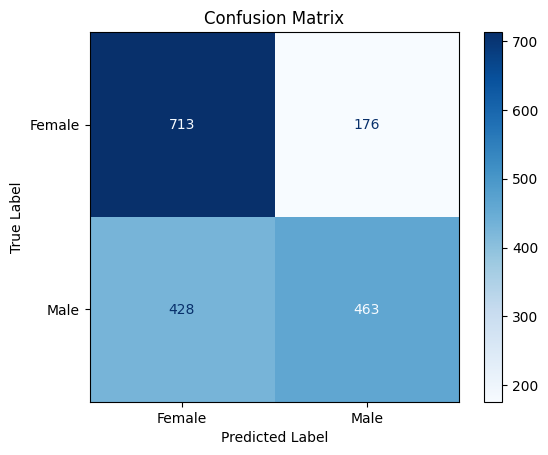

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model and get predictions
y_pred = model.predict(X_test)

# Convert the predictions from one-hot encoded to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
labels = ['Female', 'Male']  # Adjust according to your labels

plt.figure(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

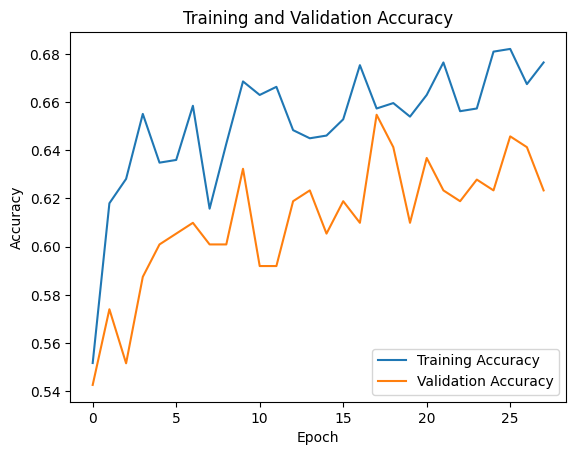

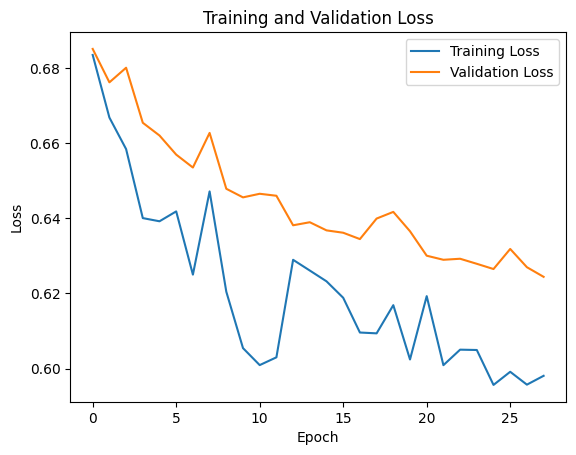

In [9]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()